References:
* https://www.youtube.com/watch?v=RyRKmZ6A25k
* https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

In [1]:
import networkx as nx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import Measure
from qiskit.quantum_info import Operator

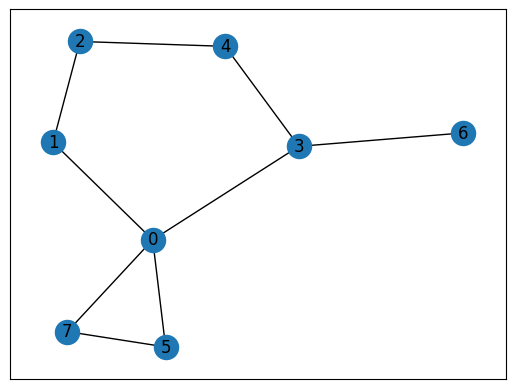

In [2]:
G = nx.Graph()
G.add_edges_from([[0,1],[0,3],[0,5],[0,7],[5,7],[1,2],[2,4],[3,4],[3,6]])
nx.draw_networkx(G)

In [3]:
operator = SparsePauliOp.from_list(
    [("IIIIIIZZ", 0.5), 
     ("IIIIZIIZ", 0.5), 
     ("IIZIIIIZ", 0.5), 
     ("ZIIIIIIZ", 0.5), 
     ("ZIZIIIII", 0.5), 
     ("IIIIIZZI", 0.5), 
     ("IIIZIZII", 0.5), 
     ("IIIZZIII", 0.5), 
     ("IZIIZIII", 0.5),]
)

print("Cost Function Hamiltonian:", operator)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIZZ', 'IIIIZIIZ', 'IIZIIIIZ', 'ZIIIIIIZ', 'ZIZIIIII', 'IIIIIZZI', 'IIIZIZII', 'IIIZZIII', 'IZIIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


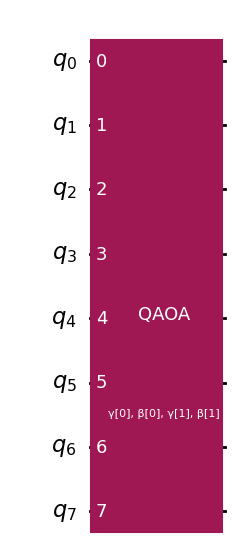

In [4]:
circuit = QAOAAnsatz(cost_operator=operator, reps=2)

circuit.draw('mpl')

In [5]:
from qiskit.transpiler import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=3)
isa_circuit = pm.run(circuit)
isa_operator = operator.apply_layout(isa_circuit.layout)

In [6]:
import numpy as np
num_params = circuit.num_parameters
x0 = 0.5* np.pi * np.random.random(num_params)
print(x0)

[0.36976165 0.84879802 1.52826007 0.20436466]


In [7]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    cost_values.append(cost)
    return cost

In [8]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

cost_values = []

estimator = StatevectorEstimator()

result = minimize(
    cost_func,
    x0,
    args=(isa_circuit, isa_operator, estimator),
    method="COBYLA",
    tol=1e-2)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.1118436081630456
       x: [ 4.012e-01  7.830e-01  8.152e-01 -2.984e-01]
    nfev: 59
   maxcv: 0.0


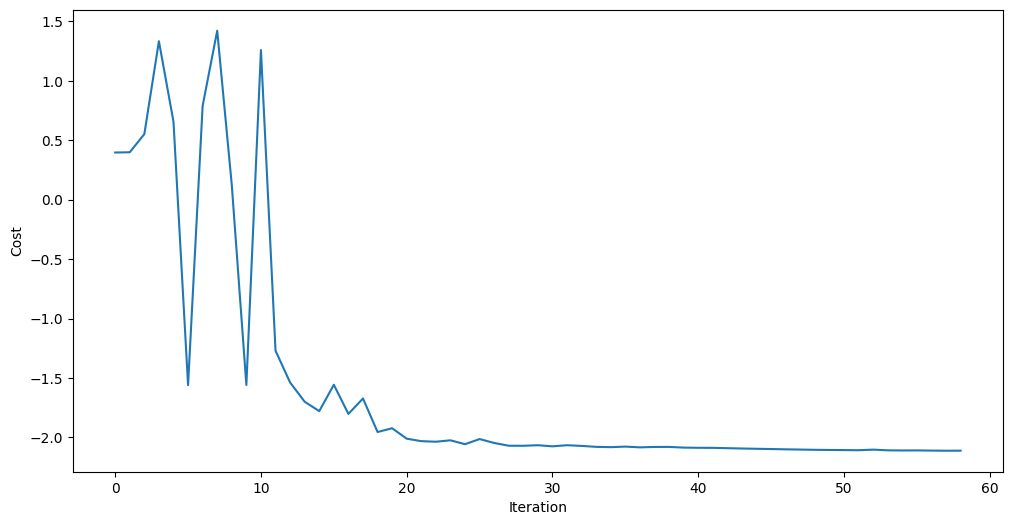

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cost_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

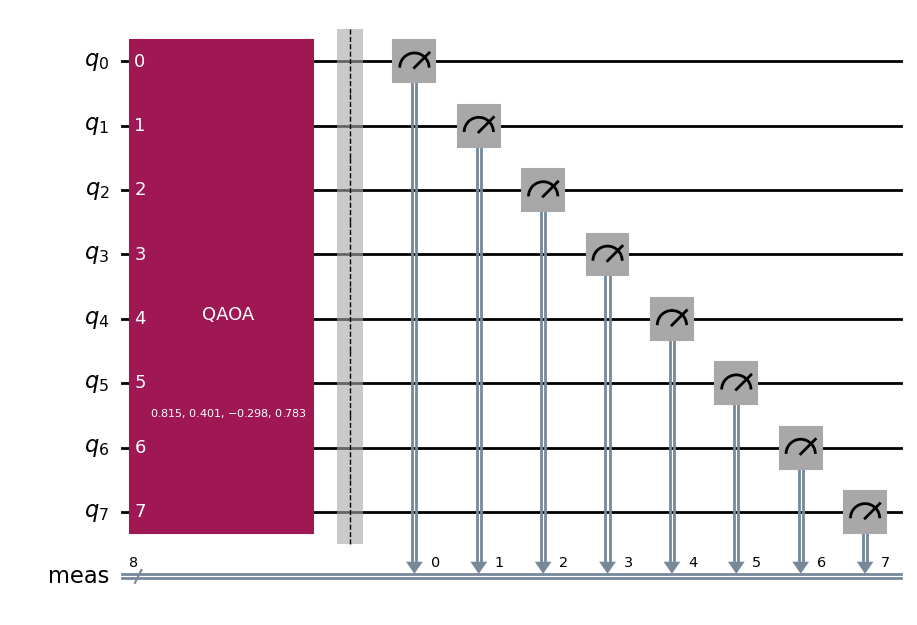

In [10]:
from qiskit.primitives import StatevectorSampler
import copy
from qiskit import ClassicalRegister

optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit.measure_all()

optimized_circuit.draw('mpl')

In [11]:
sampler = StatevectorSampler()
pub= (optimized_circuit, )
job = sampler.run([pub], shots=10000)
counts = job.result()[0].data.meas.get_counts()

In [12]:
keys = list(counts.keys())
values = list(counts.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bits = [int(digit) for digit in most_likely]
most_likely_bits.reverse()

print(most_likely_bits)

[0, 1, 0, 1, 1, 1, 0, 0]


In [13]:
colors = []
for node in G:
    if most_likely_bits[node]==0:
        colors.append("red")
    else:
        colors.append("green")

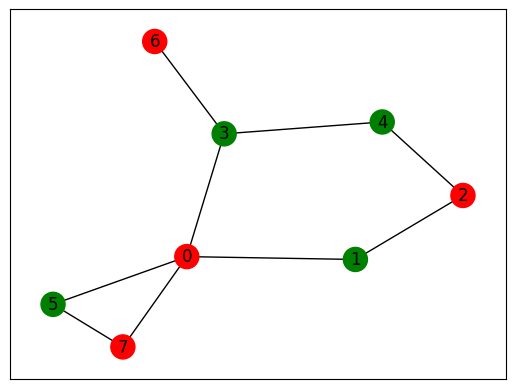

In [14]:
nx.draw_networkx(G,node_color = colors)